# FIFA 2019 Complete Player Dataset

This dataset, containing 90 attributes of 18.2k+ soccer players registered in the latest edition (2019) of the FIFA database, was obtained from [Kaggle](https://www.kaggle.com/karangadiya/fifa19). The user who made it available used a own-developed scrapper to get the information from [FIFA's website](https://sofifa.com/players). Curiously, the original dataset contains error; the very first entry, for example, states that Lionel Messi's body type is 'Messi'.

I will use the technical features contained in this dataset, and also the athletes' weight and height, to group them in technical profiles, and then I will investigate the relationships between these profiles and their assigned field position.

## Importing dependencies

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.ensemble import RandomForestClassifier
from collections import Counter

## Reading data and inspecting columns

In [2]:
df = pd.read_csv('data.csv')
print(len(df))

18207


The dataframe contains 18,207 entries.

In [3]:
for i, column in enumerate(df.columns):
    print(i, column)

0 Unnamed: 0
1 ID
2 Name
3 Age
4 Photo
5 Nationality
6 Flag
7 Overall
8 Potential
9 Club
10 Club Logo
11 Value
12 Wage
13 Special
14 Preferred Foot
15 International Reputation
16 Weak Foot
17 Skill Moves
18 Work Rate
19 Body Type
20 Real Face
21 Position
22 Jersey Number
23 Joined
24 Loaned From
25 Contract Valid Until
26 Height
27 Weight
28 LS
29 ST
30 RS
31 LW
32 LF
33 CF
34 RF
35 RW
36 LAM
37 CAM
38 RAM
39 LM
40 LCM
41 CM
42 RCM
43 RM
44 LWB
45 LDM
46 CDM
47 RDM
48 RWB
49 LB
50 LCB
51 CB
52 RCB
53 RB
54 Crossing
55 Finishing
56 HeadingAccuracy
57 ShortPassing
58 Volleys
59 Dribbling
60 Curve
61 FKAccuracy
62 LongPassing
63 BallControl
64 Acceleration
65 SprintSpeed
66 Agility
67 Reactions
68 Balance
69 ShotPower
70 Jumping
71 Stamina
72 Strength
73 LongShots
74 Aggression
75 Interceptions
76 Positioning
77 Vision
78 Penalties
79 Composure
80 Marking
81 StandingTackle
82 SlidingTackle
83 GKDiving
84 GKHandling
85 GKKicking
86 GKPositioning
87 GKReflexes
88 Release Clause


I will extract now the columns standing for Position, Height, Weight and all technical features from Crossing to SlidingTackle. I decided not to use features related exclusively to the GoalKeeper (GK) position. All these features are given as a score from 0 to 100.

In [4]:
columns = [21, 26, 27]
columns += range(54, 83)
df = df.iloc[:, columns]

Printing again column names and their assorted index.

In [5]:
for i, column in enumerate(df.columns):
    print(i, column)

0 Position
1 Height
2 Weight
3 Crossing
4 Finishing
5 HeadingAccuracy
6 ShortPassing
7 Volleys
8 Dribbling
9 Curve
10 FKAccuracy
11 LongPassing
12 BallControl
13 Acceleration
14 SprintSpeed
15 Agility
16 Reactions
17 Balance
18 ShotPower
19 Jumping
20 Stamina
21 Strength
22 LongShots
23 Aggression
24 Interceptions
25 Positioning
26 Vision
27 Penalties
28 Composure
29 Marking
30 StandingTackle
31 SlidingTackle


Are there empty entries?

In [6]:
df.isna().sum(axis = 0)

Position           60
Height             48
Weight             48
Crossing           48
Finishing          48
HeadingAccuracy    48
ShortPassing       48
Volleys            48
Dribbling          48
Curve              48
FKAccuracy         48
LongPassing        48
BallControl        48
Acceleration       48
SprintSpeed        48
Agility            48
Reactions          48
Balance            48
ShotPower          48
Jumping            48
Stamina            48
Strength           48
LongShots          48
Aggression         48
Interceptions      48
Positioning        48
Vision             48
Penalties          48
Composure          48
Marking            48
StandingTackle     48
SlidingTackle      48
dtype: int64

All technical features have exactly 48 empty entries, which prompts me to think these features are missing for the same players. Also, Position has 60 missing values. Does these 60 entries encompass the 48 entries in all other features? I will check this by checking how many rows are dropped if all missing values are dropped. 

In [7]:
len(df) - len(df.dropna())

60

These must be the 60 entries where Position is missing. Since these represent only 60/18207 = 0.3% of all entries, I will simply drop them.

In [8]:
df = df.dropna()

## Inspecting statistics

Now, for inspecting statistics, I like to visualize histogram and boxplot side-by-side. To make things easier, I will write a function for that.

In [9]:
def hist_boxplot(feature):
    fig, ax = plt.subplots(1, 2)
    ax[0].hist(feature)
    ax[1].boxplot(feature)

Now I will generate a summary of this dataset.

In [10]:
df_describe = df.describe()

Let me check the distribution of the minimum values in this summary.

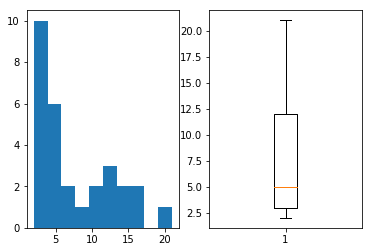

In [11]:
hist_boxplot(df_describe.loc['min'])

This tells me that all minimum values in technical features are in the range of approximately 2.5 ~ 22.5, being concentrated around the median 5. This seems adequate. 

Now for the maximum values.

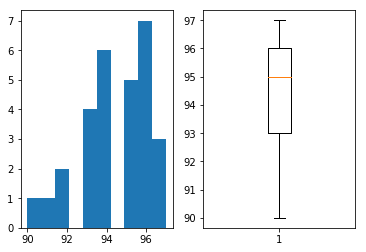

In [12]:
hist_boxplot(df_describe.loc['max'])

All maximum values are between 90 and 97, concentrated around 95, which also seems fine.

And then the average values.

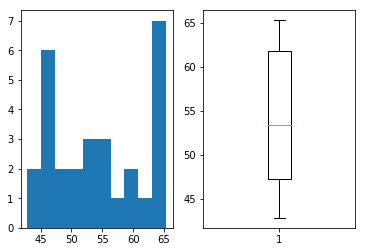

In [13]:
hist_boxplot(df_describe.loc['mean'])

They are around 40 and 65, dispersed around 54. It seems these values are diverse enough to serve our purpose.

Now, the *describe* function used above summarizes only numerical features. Which features are not numerical?

In [14]:
df.dtypes[(x not in ['int64', 'float64'] for x in df.dtypes)]

Position    object
Height      object
Weight      object
dtype: object

Let me inspect the Height column.

In [15]:
df['Height'].head()

0     5'7
1     6'2
2     5'9
3     6'4
4    5'11
Name: Height, dtype: object

Height is given in the Imperial System: feet + inches. I will convert this to centimeters. For that, I need to split these strings at the apostrophe, then convert both feet and inches to centimeters, and sum them up.

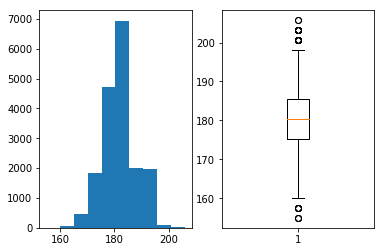

In [16]:
df['Height'] = df['Height'].str.split('\'')
df['Height'] = [30.48*int(elem[0]) + 2.54*int(elem[1]) for elem in df['Height']]
hist_boxplot(df['Height'])

The distribution of heights is quite normal: the median is around 180, and there are some outliers both above 200 cm and below 160 cm.

Let me check the Weight column now.

In [17]:
df['Weight'].head()

0    159lbs
1    183lbs
2    150lbs
3    168lbs
4    154lbs
Name: Weight, dtype: object

It is given in pounds. Although it is not necessary, I want to convert them to kilogram. The easiest way seems to be splitting these strings at the 'l' character, then converting the number to kilogram, and discarding the second part of the string.

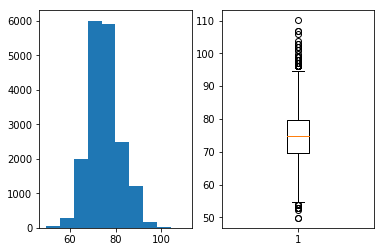

In [18]:
df['Weight'] = df['Weight'].str.split('l')
df['Weight'] = [int(elem[0])*0.453 for elem in df['Weight']]
hist_boxplot(df['Weight'])

The distribution of weights is also quite normal. The median is around 75 kg, and there are several outliers above 95 kg and also below 55 kg.

## Preparing dataset to ML

Now I will save the Position column to a new array, to use later.

In [19]:
position = np.array(df['Position'])

Then I will drop the Position column from the features dataframe, and use Scikit Learn's MinMaxScaler to normalize all numerical features in the range (0, 1).

In [20]:
df = df.drop(['Position'], axis = 1)
scaler = MinMaxScaler()
df_train = scaler.fit_transform(df)

## K-Means Clustering

Now I will check how many groups can be reasonable formed based on the technical features. I will try grouping the data from 1 to 11 groups. Eleven is the number of players in the field, it seems to me that this is a good cutoff for the maximum number of groups.

Text(0.5, 1.0, 'Elbow Method For Optimal k')

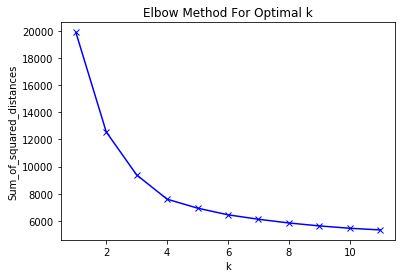

In [21]:
ssd = []
K = range(1, 12)
for k in K:
    km = KMeans(n_clusters = k)
    km = km.fit(df_train)
    ssd.append(km.inertia_)

plt.plot(K[:21], ssd[:21], 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')

The plot suggests that 4 is a good number for splitting the data in, given the elbow at k = 4. Nevertheless, I will also use the silhouette method to confirm this suggestion.

For visualizing the data, since there are 31 features, I will first reduce them to 2 dimensions with PCA.

In [22]:
pca = PCA(n_components = 2)
df_pca = pca.fit_transform(df_train)
exp_var = [round(i, 1) for i in pca.explained_variance_ratio_*100]

The following code to implement the silhouette method was adapted from https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html. I will also check group numbers ranging from 2 to 11.

For n_clusters = 2 The average silhouette_score is : 0.4703559214248003
For n_clusters = 3 The average silhouette_score is : 0.28531193071854866
For n_clusters = 4 The average silhouette_score is : 0.27054205633034145
For n_clusters = 5 The average silhouette_score is : 0.24283290543765237
For n_clusters = 6 The average silhouette_score is : 0.21740198751489614
For n_clusters = 7 The average silhouette_score is : 0.20808338965236395
For n_clusters = 8 The average silhouette_score is : 0.20280346274861658
For n_clusters = 9 The average silhouette_score is : 0.18906364613379129
For n_clusters = 10 The average silhouette_score is : 0.1836586388597641
For n_clusters = 11 The average silhouette_score is : 0.17382764780890356


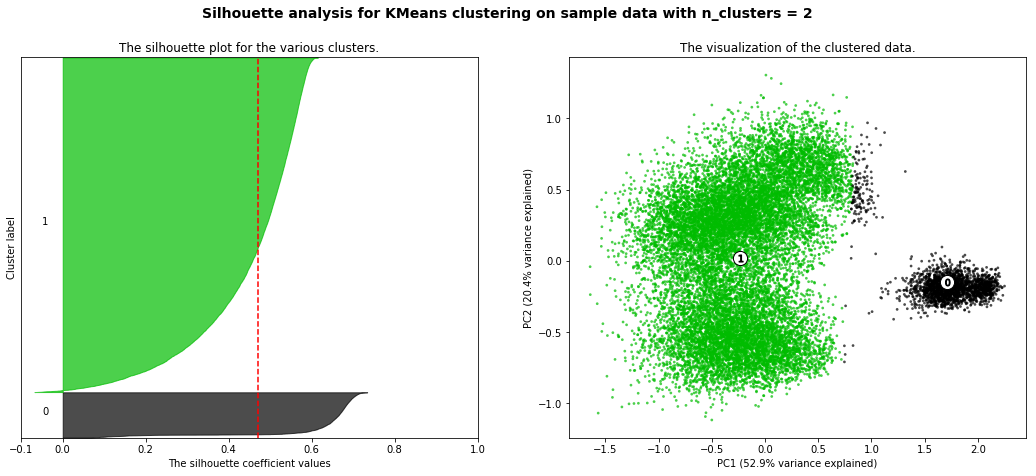

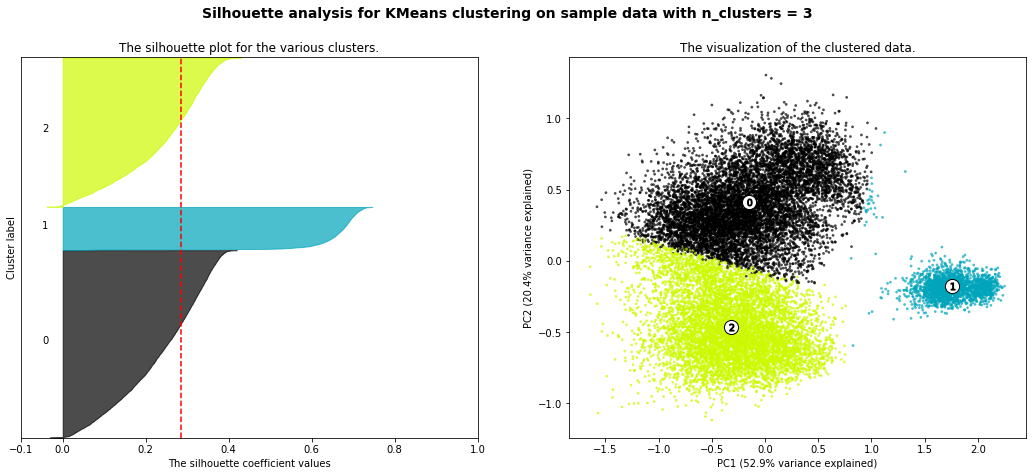

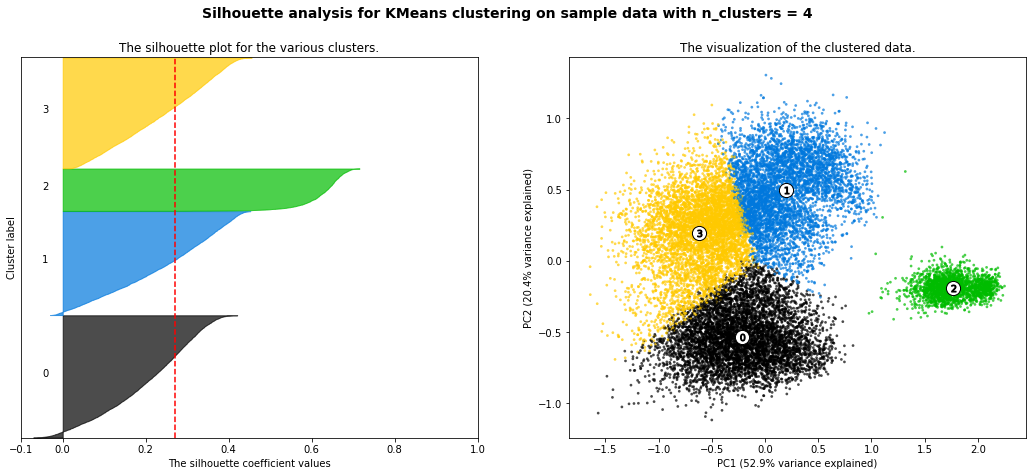

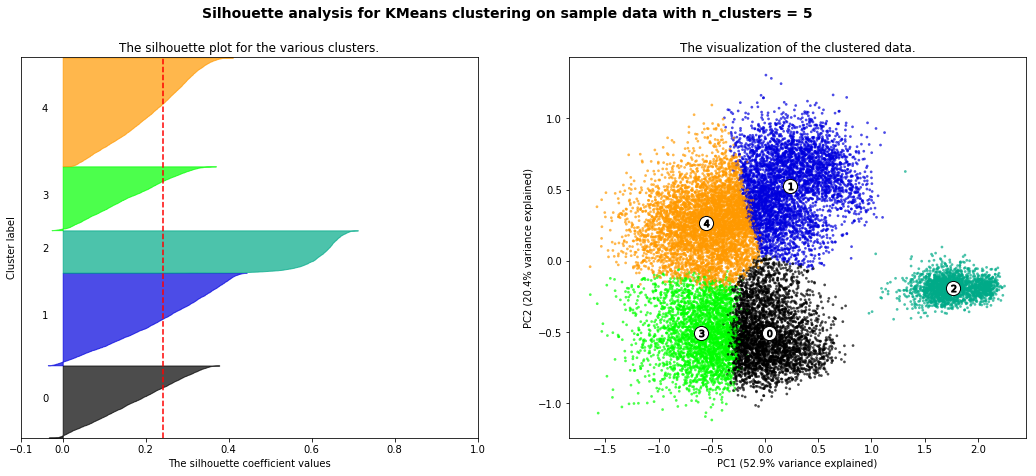

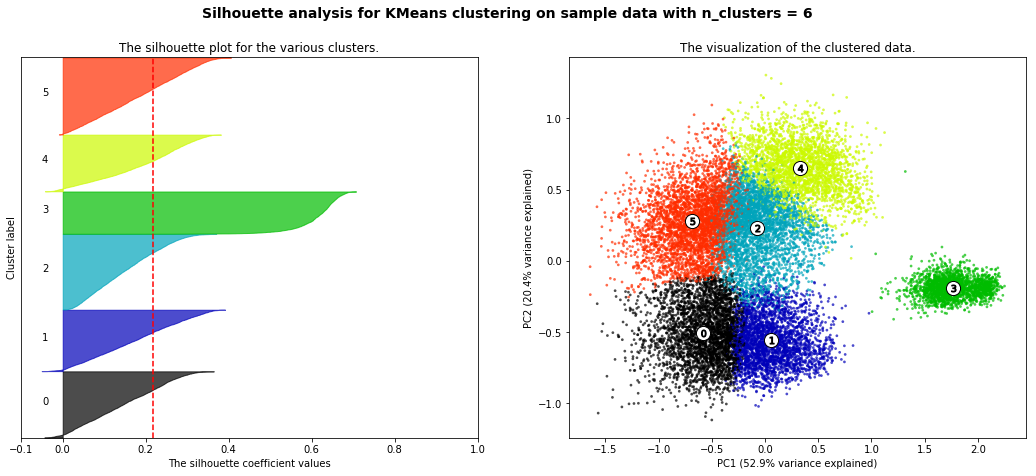

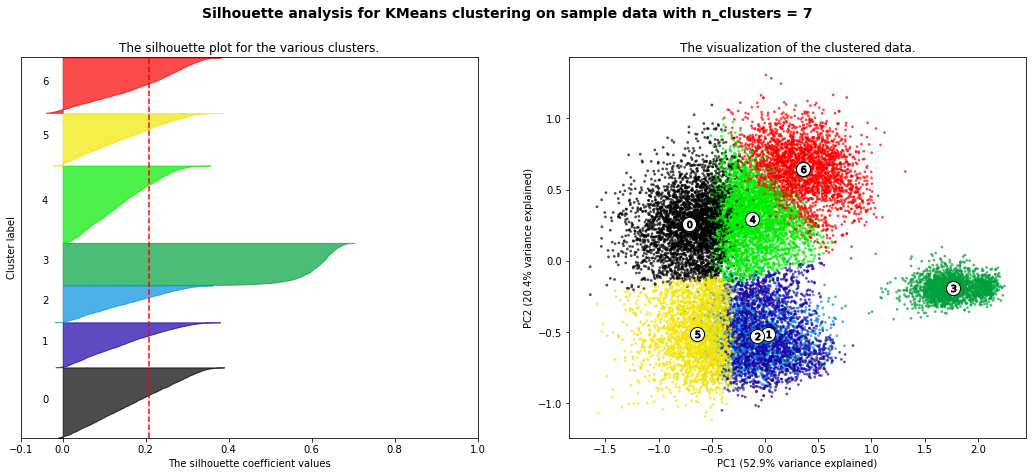

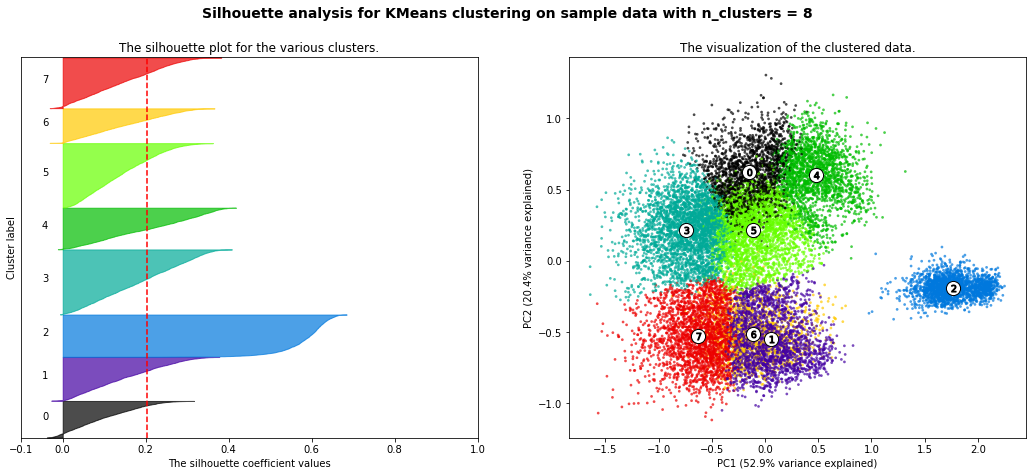

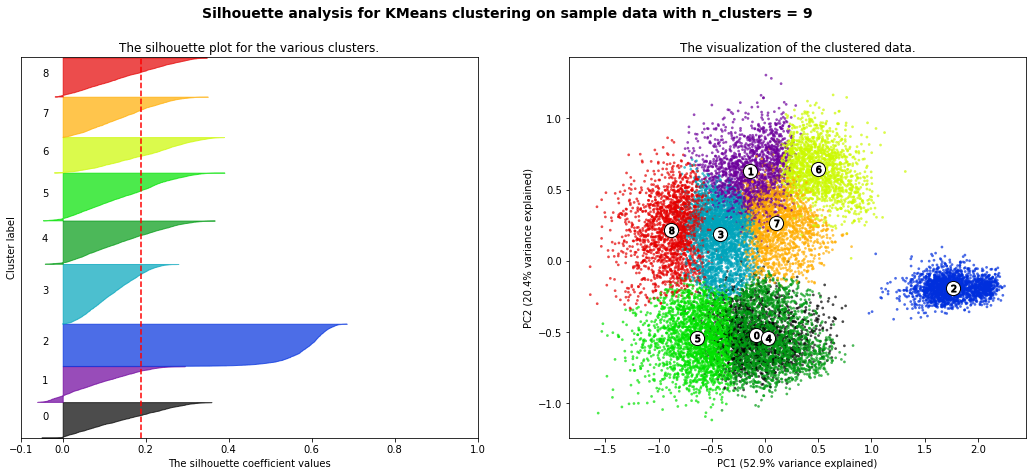

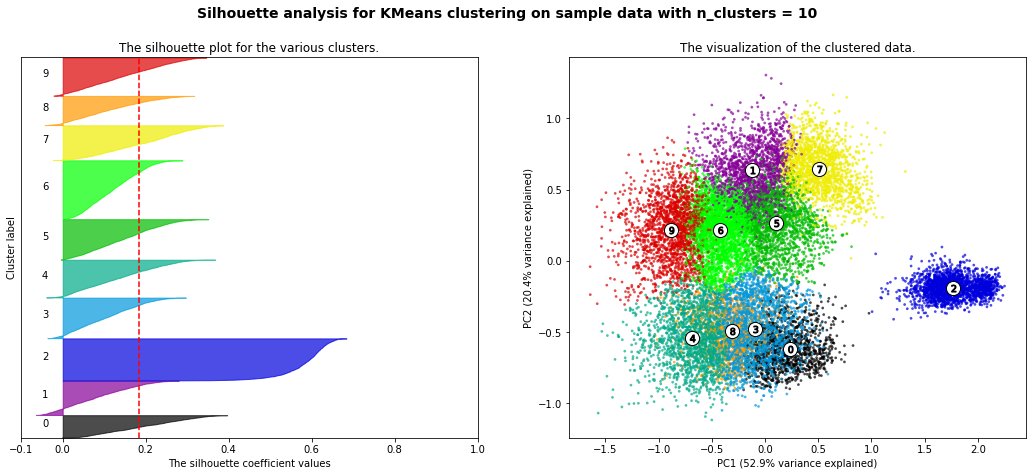

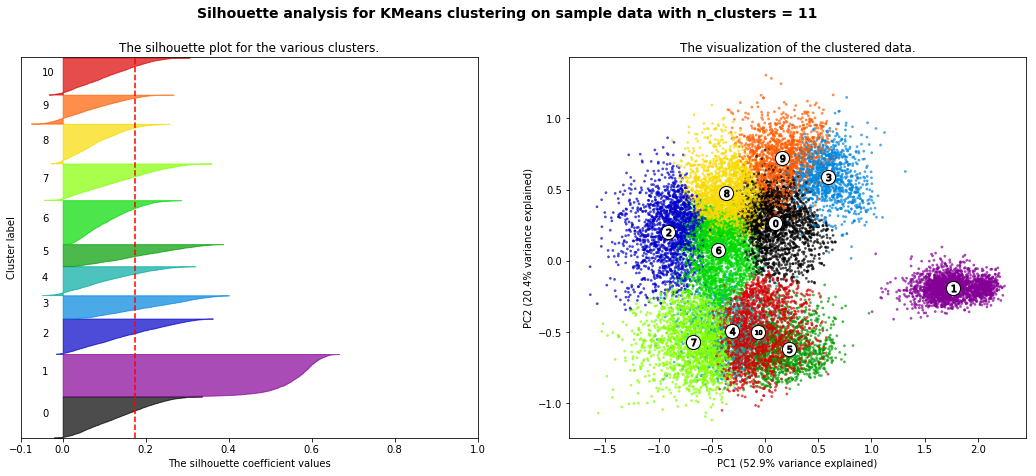

In [23]:
range_n_clusters = range(2, 12)
for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(df_train) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(df_train)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(df_train, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(df_train, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x = silhouette_avg, color = "red", linestyle = "--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(df_pca[:, 0], df_pca[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    centers = pca.transform(centers)
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel('PC1 (' + str(exp_var[0]) + '% variance explained)')
    ax2.set_ylabel('PC2 (' + str(exp_var[1]) + '% variance explained)')

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

These plots suggest that all number of k would be acceptable choices, since all cluster plots top above the average silhouette score (red vertical line). From both analyses, I will decide to split the data in 4 groups, where there is one cluster (number 2) visually separated from the other 3, which are further united within a large blob. This means that these 3 groups are harder to separate from the technical features.

In [24]:
km = KMeans(n_clusters = 4, n_init = 100, max_iter = 300, verbose = 1, random_state = 24)
km.fit(df_train)

Initialization complete
start iteration
done sorting
end inner loop
Iteration 0, inertia 8715.039462399069
start iteration
done sorting
end inner loop
Iteration 1, inertia 7821.825152164395
start iteration
done sorting
end inner loop
Iteration 2, inertia 7656.210487626938
start iteration
done sorting
end inner loop
Iteration 3, inertia 7618.7423404524325
start iteration
done sorting
end inner loop
Iteration 4, inertia 7606.178284782491
start iteration
done sorting
end inner loop
Iteration 5, inertia 7600.820958228553
start iteration
done sorting
end inner loop
Iteration 6, inertia 7598.2860137638
start iteration
done sorting
end inner loop
Iteration 7, inertia 7597.16273462965
start iteration
done sorting
end inner loop
Iteration 8, inertia 7596.487825170801
start iteration
done sorting
end inner loop
Iteration 9, inertia 7595.908358287776
start iteration
done sorting
end inner loop
Iteration 10, inertia 7595.657199501823
start iteration
done sorting
end inner loop
Iteration 11, inerti

Iteration 13, inertia 7595.505951351352
center shift 8.384985e-04 within tolerance 3.539959e-06
Initialization complete
start iteration
done sorting
end inner loop
Iteration 0, inertia 9426.878901933595
start iteration
done sorting
end inner loop
Iteration 1, inertia 8241.751982574613
start iteration
done sorting
end inner loop
Iteration 2, inertia 7817.078938308568
start iteration
done sorting
end inner loop
Iteration 3, inertia 7663.055779326043
start iteration
done sorting
end inner loop
Iteration 4, inertia 7618.38362620646
start iteration
done sorting
end inner loop
Iteration 5, inertia 7605.2105587637425
start iteration
done sorting
end inner loop
Iteration 6, inertia 7600.078433601408
start iteration
done sorting
end inner loop
Iteration 7, inertia 7597.961594885445
start iteration
done sorting
end inner loop
Iteration 8, inertia 7596.965027961113
start iteration
done sorting
end inner loop
Iteration 9, inertia 7596.310063482688
start iteration
done sorting
end inner loop
Iterat

Iteration 8, inertia 7601.2692806471505
start iteration
done sorting
end inner loop
Iteration 9, inertia 7598.49989014455
start iteration
done sorting
end inner loop
Iteration 10, inertia 7597.216948236897
start iteration
done sorting
end inner loop
Iteration 11, inertia 7596.548310488429
start iteration
done sorting
end inner loop
Iteration 12, inertia 7596.003193456684
start iteration
done sorting
end inner loop
Iteration 13, inertia 7595.6728652907095
start iteration
done sorting
end inner loop
Iteration 14, inertia 7595.577043494121
start iteration
done sorting
end inner loop
Iteration 15, inertia 7595.537732049991
start iteration
done sorting
end inner loop
Iteration 16, inertia 7595.517809756596
center shift 1.717809e-03 within tolerance 3.539959e-06
Initialization complete
start iteration
done sorting
end inner loop
Iteration 0, inertia 8843.70853474172
start iteration
done sorting
end inner loop
Iteration 1, inertia 7995.556833698161
start iteration
done sorting
end inner loop


done sorting
end inner loop
Iteration 8, inertia 7596.038970806969
start iteration
done sorting
end inner loop
Iteration 9, inertia 7595.706700011499
start iteration
done sorting
end inner loop
Iteration 10, inertia 7595.583036093569
start iteration
done sorting
end inner loop
Iteration 11, inertia 7595.541823412345
start iteration
done sorting
end inner loop
Iteration 12, inertia 7595.517809756596
start iteration
done sorting
end inner loop
Iteration 13, inertia 7595.516024716465
center shift 5.529031e-04 within tolerance 3.539959e-06
Initialization complete
start iteration
done sorting
end inner loop
Iteration 0, inertia 11277.728523889842
start iteration
done sorting
end inner loop
Iteration 1, inertia 9094.734037728696
start iteration
done sorting
end inner loop
Iteration 2, inertia 8169.952295015355
start iteration
done sorting
end inner loop
Iteration 3, inertia 7806.252110900848
start iteration
done sorting
end inner loop
Iteration 4, inertia 7643.470726542992
start iteration
do

Iteration 12, inertia 7596.717651565939
start iteration
done sorting
end inner loop
Iteration 13, inertia 7596.038447941702
start iteration
done sorting
end inner loop
Iteration 14, inertia 7595.729661863998
start iteration
done sorting
end inner loop
Iteration 15, inertia 7595.600402163252
start iteration
done sorting
end inner loop
Iteration 16, inertia 7595.553228310899
start iteration
done sorting
end inner loop
Iteration 17, inertia 7595.53223338383
start iteration
done sorting
end inner loop
Iteration 18, inertia 7595.511838907608
start iteration
done sorting
end inner loop
Iteration 19, inertia 7595.505951351352
center shift 8.384985e-04 within tolerance 3.539959e-06
Initialization complete
start iteration
done sorting
end inner loop
Iteration 0, inertia 8373.170482272299
start iteration
done sorting
end inner loop
Iteration 1, inertia 7660.914257767178
start iteration
done sorting
end inner loop
Iteration 2, inertia 7609.852264860148
start iteration
done sorting
end inner loop


Iteration 9, inertia 7595.511838907608
start iteration
done sorting
end inner loop
Iteration 10, inertia 7595.505951351352
center shift 8.384985e-04 within tolerance 3.539959e-06
Initialization complete
start iteration
done sorting
end inner loop
Iteration 0, inertia 10182.545132304449
start iteration
done sorting
end inner loop
Iteration 1, inertia 9477.92386081261
start iteration
done sorting
end inner loop
Iteration 2, inertia 9048.90469218255
start iteration
done sorting
end inner loop
Iteration 3, inertia 8703.88069291032
start iteration
done sorting
end inner loop
Iteration 4, inertia 8480.39507364855
start iteration
done sorting
end inner loop
Iteration 5, inertia 8297.573098584053
start iteration
done sorting
end inner loop
Iteration 6, inertia 8102.24910520939
start iteration
done sorting
end inner loop
Iteration 7, inertia 7937.123998660448
start iteration
done sorting
end inner loop
Iteration 8, inertia 7817.0050046992
start iteration
done sorting
end inner loop
Iteration 9,

Iteration 4, inertia 7838.8737559094625
start iteration
done sorting
end inner loop
Iteration 5, inertia 7745.691700212153
start iteration
done sorting
end inner loop
Iteration 6, inertia 7685.81493617402
start iteration
done sorting
end inner loop
Iteration 7, inertia 7649.465676219094
start iteration
done sorting
end inner loop
Iteration 8, inertia 7627.221943558956
start iteration
done sorting
end inner loop
Iteration 9, inertia 7612.7233182334585
start iteration
done sorting
end inner loop
Iteration 10, inertia 7605.705289057501
start iteration
done sorting
end inner loop
Iteration 11, inertia 7601.335906830136
start iteration
done sorting
end inner loop
Iteration 12, inertia 7598.495755006951
start iteration
done sorting
end inner loop
Iteration 13, inertia 7597.055630933746
start iteration
done sorting
end inner loop
Iteration 14, inertia 7596.224689117401
start iteration
done sorting
end inner loop
Iteration 15, inertia 7595.791919047118
start iteration
done sorting
end inner lo

Iteration 10, inertia 7602.141773295144
start iteration
done sorting
end inner loop
Iteration 11, inertia 7599.126726241053
start iteration
done sorting
end inner loop
Iteration 12, inertia 7597.338096281559
start iteration
done sorting
end inner loop
Iteration 13, inertia 7596.382297606688
start iteration
done sorting
end inner loop
Iteration 14, inertia 7595.8349521817745
start iteration
done sorting
end inner loop
Iteration 15, inertia 7595.651751496532
start iteration
done sorting
end inner loop
Iteration 16, inertia 7595.573683499721
start iteration
done sorting
end inner loop
Iteration 17, inertia 7595.546901957576
start iteration
done sorting
end inner loop
Iteration 18, inertia 7595.523034881047
start iteration
done sorting
end inner loop
Iteration 19, inertia 7595.508258010508
center shift 1.566585e-03 within tolerance 3.539959e-06
Initialization complete
start iteration
done sorting
end inner loop
Iteration 0, inertia 8065.7744211666295
start iteration
done sorting
end inner 

done sorting
end inner loop
Iteration 0, inertia 12192.293620464403
start iteration
done sorting
end inner loop
Iteration 1, inertia 10662.686978561711
start iteration
done sorting
end inner loop
Iteration 2, inertia 9306.32229488165
start iteration
done sorting
end inner loop
Iteration 3, inertia 8321.471564579098
start iteration
done sorting
end inner loop
Iteration 4, inertia 7833.709773983425
start iteration
done sorting
end inner loop
Iteration 5, inertia 7710.9220977763025
start iteration
done sorting
end inner loop
Iteration 6, inertia 7658.9803917880245
start iteration
done sorting
end inner loop
Iteration 7, inertia 7631.385790269862
start iteration
done sorting
end inner loop
Iteration 8, inertia 7614.595984303337
start iteration
done sorting
end inner loop
Iteration 9, inertia 7606.324587130652
start iteration
done sorting
end inner loop
Iteration 10, inertia 7601.79679343349
start iteration
done sorting
end inner loop
Iteration 11, inertia 7598.799071370119
start iteration


Iteration 5, inertia 7814.98567057502
start iteration
done sorting
end inner loop
Iteration 6, inertia 7725.2010950357335
start iteration
done sorting
end inner loop
Iteration 7, inertia 7670.632419174783
start iteration
done sorting
end inner loop
Iteration 8, inertia 7640.972533764619
start iteration
done sorting
end inner loop
Iteration 9, inertia 7621.325264931598
start iteration
done sorting
end inner loop
Iteration 10, inertia 7609.80878709856
start iteration
done sorting
end inner loop
Iteration 11, inertia 7603.867350743396
start iteration
done sorting
end inner loop
Iteration 12, inertia 7600.174872588335
start iteration
done sorting
end inner loop
Iteration 13, inertia 7597.848214605684
start iteration
done sorting
end inner loop
Iteration 14, inertia 7596.615867444559
start iteration
done sorting
end inner loop
Iteration 15, inertia 7595.95468770028
start iteration
done sorting
end inner loop
Iteration 16, inertia 7595.6927526828795
start iteration
done sorting
end inner loo

end inner loop
Iteration 3, inertia 7598.695815005879
start iteration
done sorting
end inner loop
Iteration 4, inertia 7596.2352651659985
start iteration
done sorting
end inner loop
Iteration 5, inertia 7595.676051661459
start iteration
done sorting
end inner loop
Iteration 6, inertia 7595.564021363012
start iteration
done sorting
end inner loop
Iteration 7, inertia 7595.5289622151895
start iteration
done sorting
end inner loop
Iteration 8, inertia 7595.509704944012
start iteration
done sorting
end inner loop
Iteration 9, inertia 7595.505951351352
center shift 6.356676e-04 within tolerance 3.539959e-06
Initialization complete
start iteration
done sorting
end inner loop
Iteration 0, inertia 7940.030605889983
start iteration
done sorting
end inner loop
Iteration 1, inertia 7683.930330433562
start iteration
done sorting
end inner loop
Iteration 2, inertia 7630.284753062306
start iteration
done sorting
end inner loop
Iteration 3, inertia 7611.506592395398
start iteration
done sorting
end i

Iteration 18, inertia 7595.5067977645795
center shift 9.646170e-04 within tolerance 3.539959e-06
Initialization complete
start iteration
done sorting
end inner loop
Iteration 0, inertia 8315.93634312022
start iteration
done sorting
end inner loop
Iteration 1, inertia 7991.8738714108895
start iteration
done sorting
end inner loop
Iteration 2, inertia 7847.38612820836
start iteration
done sorting
end inner loop
Iteration 3, inertia 7754.062065272198
start iteration
done sorting
end inner loop
Iteration 4, inertia 7689.786647798986
start iteration
done sorting
end inner loop
Iteration 5, inertia 7651.973323986233
start iteration
done sorting
end inner loop
Iteration 6, inertia 7629.037260353763
start iteration
done sorting
end inner loop
Iteration 7, inertia 7613.4925804705235
start iteration
done sorting
end inner loop
Iteration 8, inertia 7605.86654519853
start iteration
done sorting
end inner loop
Iteration 9, inertia 7601.3924684049725
start iteration
done sorting
end inner loop
Itera

Iteration 12, inertia 7597.831723959251
start iteration
done sorting
end inner loop
Iteration 13, inertia 7596.5980245088485
start iteration
done sorting
end inner loop
Iteration 14, inertia 7595.945551312893
start iteration
done sorting
end inner loop
Iteration 15, inertia 7595.6927526828795
start iteration
done sorting
end inner loop
Iteration 16, inertia 7595.5890184906575
start iteration
done sorting
end inner loop
Iteration 17, inertia 7595.553228310899
start iteration
done sorting
end inner loop
Iteration 18, inertia 7595.53223338383
start iteration
done sorting
end inner loop
Iteration 19, inertia 7595.511838907608
start iteration
done sorting
end inner loop
Iteration 20, inertia 7595.505951351352
center shift 8.384985e-04 within tolerance 3.539959e-06
Initialization complete
start iteration
done sorting
end inner loop
Iteration 0, inertia 8305.104145834344
start iteration
done sorting
end inner loop
Iteration 1, inertia 7791.907162612418
start iteration
done sorting
end inner l

Initialization complete
start iteration
done sorting
end inner loop
Iteration 0, inertia 9499.714013843313
start iteration
done sorting
end inner loop
Iteration 1, inertia 8367.129256933546
start iteration
done sorting
end inner loop
Iteration 2, inertia 7924.353383154764
start iteration
done sorting
end inner loop
Iteration 3, inertia 7692.636355022727
start iteration
done sorting
end inner loop
Iteration 4, inertia 7630.607029526966
start iteration
done sorting
end inner loop
Iteration 5, inertia 7611.656776067569
start iteration
done sorting
end inner loop
Iteration 6, inertia 7604.964599863899
start iteration
done sorting
end inner loop
Iteration 7, inertia 7600.787263868061
start iteration
done sorting
end inner loop
Iteration 8, inertia 7598.253141145231
start iteration
done sorting
end inner loop
Iteration 9, inertia 7596.901385849943
start iteration
done sorting
end inner loop
Iteration 10, inertia 7596.119891471468
start iteration
done sorting
end inner loop
Iteration 11, iner

start iteration
done sorting
end inner loop
Iteration 6, inertia 7600.869197046339
start iteration
done sorting
end inner loop
Iteration 7, inertia 7598.2644941089375
start iteration
done sorting
end inner loop
Iteration 8, inertia 7597.146336973461
start iteration
done sorting
end inner loop
Iteration 9, inertia 7596.480781599061
start iteration
done sorting
end inner loop
Iteration 10, inertia 7595.911651299312
start iteration
done sorting
end inner loop
Iteration 11, inertia 7595.664239595733
start iteration
done sorting
end inner loop
Iteration 12, inertia 7595.573714324653
start iteration
done sorting
end inner loop
Iteration 13, inertia 7595.535796978087
start iteration
done sorting
end inner loop
Iteration 14, inertia 7595.517809756596
center shift 1.560698e-03 within tolerance 3.539959e-06
Initialization complete
start iteration
done sorting
end inner loop
Iteration 0, inertia 9175.781920895297
start iteration
done sorting
end inner loop
Iteration 1, inertia 8588.106331239916
s

Initialization complete
start iteration
done sorting
end inner loop
Iteration 0, inertia 8514.027061309936
start iteration
done sorting
end inner loop
Iteration 1, inertia 7984.390849109954
start iteration
done sorting
end inner loop
Iteration 2, inertia 7706.485511074589
start iteration
done sorting
end inner loop
Iteration 3, inertia 7617.997357286108
start iteration
done sorting
end inner loop
Iteration 4, inertia 7602.287351340712
start iteration
done sorting
end inner loop
Iteration 5, inertia 7598.542485059681
start iteration
done sorting
end inner loop
Iteration 6, inertia 7597.145006268874
start iteration
done sorting
end inner loop
Iteration 7, inertia 7596.430889478078
start iteration
done sorting
end inner loop
Iteration 8, inertia 7595.90575659753
start iteration
done sorting
end inner loop
Iteration 9, inertia 7595.634458297108
start iteration
done sorting
end inner loop
Iteration 10, inertia 7595.571184082502
start iteration
done sorting
end inner loop
Iteration 11, inert

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=4, n_init=100, n_jobs=None, precompute_distances='auto',
    random_state=24, tol=0.0001, verbose=1)

## Relationship between groups and positions

Now I will compare the natural classification given by the K-Means algorithm with the Position each player is assigned to. An array with group affiliation can be retrieved from the trained *kmeans* object. Then I will convert the number of players to proportions within each Position.

In [25]:
groups = km.labels_

compar = []
for i in range(0, len(position)):
    elem = tuple((position[i], groups[i]))
    compar.append(elem)
count = Counter(compar)

compar = pd.DataFrame({'Position' : [i[0] for i in list(count.keys())],
              'Group' : [i[1] for i in list(count.keys())],
              'N' : list(count.values())})
compar = compar.sort_values(['Position', 'Group'])

compar_perc = pd.DataFrame()
pos = compar['Position'].unique()
for p in pos:
    compar_p = compar[compar['Position'] == p]
    sum_N = sum(compar_p['N'])
    compar_p['N'] = compar_p['N']/sum_N
    compar_perc = compar_perc.append(compar_p)
compar_perc = compar_perc.sort_values(['Group', 'N', 'Position'])

print(compar_perc)

C:\Users\Denny\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


   Position  Group         N
11       ST      0  0.033922
6        RS      0  0.054187
14       LS      0  0.072464
39       CF      0  0.081081
9        CB      0  0.087177
25       RW      0  0.121622
19       LW      0  0.128609
18      LAM      0  0.142857
7       RCB      0  0.152568
15      LCB      0  0.175926
26       LM      0  0.234703
43       RF      0  0.250000
17       RM      0  0.253559
31       LF      0  0.266667
35      RAM      0  0.285714
12      CAM      0  0.292276
28       RB      0  0.512781
21       LB      0  0.543873
40      RWB      0  0.551724
41      LWB      0  0.576923
13      CDM      0  0.590717
27       CM      0  0.606169
24      RDM      0  0.774194
10      LDM      0  0.777778
8       LCM      0  0.779747
4       RCM      0  0.826087
70       GK      1  0.000494
68       RW      1  0.002703
63       ST      1  0.004647
69       RS      1  0.004926
..      ...    ...       ...
76       ST      2  0.000465
74       CB      2  0.000562
75       RB   

It seems most, if not all, positions were assigned to more than one group. We can check that visually in a barplot, but in order to do so, first we need to fill in the dataframe with those pairs where certain Position/Group entries do not exist (therefore, with value 0). 

In [26]:
compar_perc_barplot = pd.DataFrame({'Position' : sum([[elem] * 4 for elem in np.unique(position)], []),
                                    'Group' : sum([['0', '1', '2', '3'] * len(np.unique(position))], []),
                                    'N' : [0] * 4 * len(np.unique(position))})
for row in range(0, len(compar_perc_barplot)):
    pos = compar_perc_barplot.iloc[row, 0]
    gro = int(compar_perc_barplot.iloc[row, 1])
    reg = compar_perc.loc[(compar_perc['Position'] == pos)&(compar_perc['Group'] == gro), :]
    if(len(reg) > 0):
        compar_perc_barplot.iloc[row, 2] = reg['N'].values

Now the barplot.

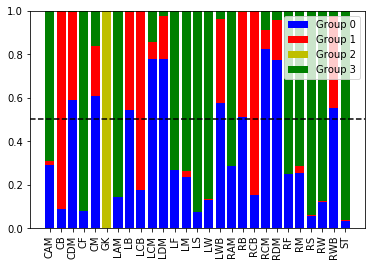

In [27]:
p0 = plt.bar(compar_perc_barplot['Position'][compar_perc_barplot['Group'] == '0'], 
             compar_perc_barplot['N'][compar_perc_barplot['Group'] == '0'], 
             color = 'b')
p1 = plt.bar(compar_perc_barplot['Position'][compar_perc_barplot['Group'] == '1'], 
             compar_perc_barplot['N'][compar_perc_barplot['Group'] == '1'], 
             bottom = np.array(compar_perc_barplot['N'][compar_perc_barplot['Group'] == '0']),
             color = 'r')
p2 = plt.bar(compar_perc_barplot['Position'][compar_perc_barplot['Group'] == '2'], 
             compar_perc_barplot['N'][compar_perc_barplot['Group'] == '2'], 
             bottom = np.array(compar_perc_barplot['N'][compar_perc_barplot['Group'] == '0']) +
                      np.array(compar_perc_barplot['N'][compar_perc_barplot['Group'] == '1']),
             color = 'y')
p3 = plt.bar(compar_perc_barplot['Position'][compar_perc_barplot['Group'] == '3'], 
             compar_perc_barplot['N'][compar_perc_barplot['Group'] == '3'], 
             bottom = np.array(compar_perc_barplot['N'][compar_perc_barplot['Group'] == '0']) +
                      np.array(compar_perc_barplot['N'][compar_perc_barplot['Group'] == '1']) +
                      np.array(compar_perc_barplot['N'][compar_perc_barplot['Group'] == '2']),
             color = 'g')
plt.xticks(rotation = 90)
plt.axhline(0.5, color = 'black', linestyle = '--')
plt.legend((p0[0], p1[0], p2[0], p3[0]), ('Group 0', 'Group 1', 'Group 2', 'Group 3'))

Indeed several positions were assigned to more than one group, but most of them were dominated by one particular group, except LAM and RB which have roughly the same proportions in groups 0 and 1. Besides, group 2 is practically composed of the GK position alone. This is the group that was most separated from the other three in the cluster plots; it seems reasonable that the technical features of GoalKeepers would be quite different than those of all other positions.

Now I would like to check the number of positions designated to each Group. I will separate the data to highlight the number of Positions where the proportion inside that Group was higher or lower than 50%.

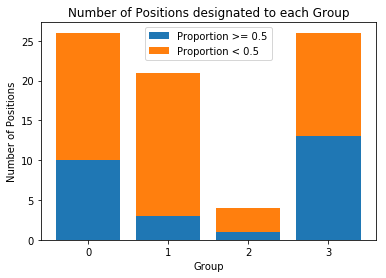

In [28]:
counter1 = Counter(compar_perc[compar_perc['N'] >= 0.5]['Group'])
counter1 = dict(sorted(counter1.items(), key = lambda x: x[0]))
x = [str(elem) for elem in list(counter1.keys())]
p1 = plt.bar(x, counter1.values())
counter2 = Counter(compar_perc[compar_perc['N'] < 0.5]['Group'])
counter2 = dict(sorted(counter2.items(), key = lambda x: x[0]))
x = [str(elem) for elem in list(counter2.keys())]
p2 = plt.bar(x, counter2.values(), bottom = list(counter1.values()))
plt.title('Number of Positions designated to each Group')
plt.xlabel('Group')
plt.ylabel('Number of Positions')
plt.legend((p1[0], p2[0]), ('Proportion >= 0.5', 'Proportion < 0.5'))

Given this threshold of 50%, Group 0 is dominated by 10 Positions, Group 1 by 3 Positions, Group 2 by 1 Position and Group 3 by 13 Positions. I can now check which are the Positions that best characterize each Group.

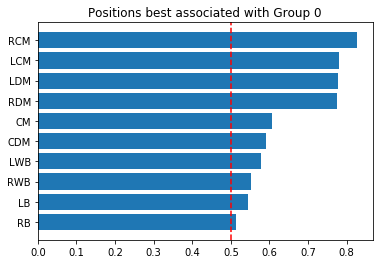

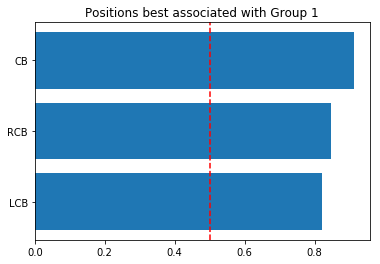

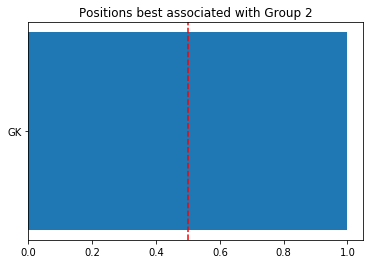

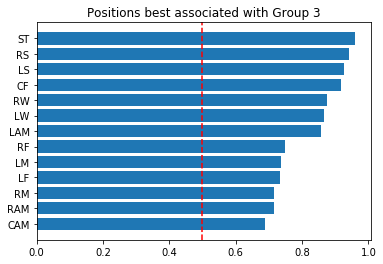

In [29]:
for i in range(4):
    g = compar_perc[(compar_perc['Group'] == i)&(compar_perc['N'] >= 0.5)][['Position', 'N']]
    g = g.sort_values(by = 'N')
    plt.barh(g['Position'], g['N'])
    plt.axvline(0.5, color = 'r', linestyle = '--')
    plt.title('Positions best associated with Group ' + str(i))
    plt.show()

## Random Forest

Finally, I can fit a Random Forest Classifier to determine the most important technical features discriminating these 4 Groups.

In [30]:
rfc = RandomForestClassifier()
rfc.fit(df_train, groups)
importances = rfc.feature_importances_
features = df.columns
df_imp = pd.DataFrame({'Features' : features, 'Importance' : importances})
df_imp = df_imp.sort_values(by = 'Importance', ascending = False)
df_imp['Sum Importance'] = df_imp['Importance'].cumsum()
df_imp = df_imp.sort_values(by = 'Importance')

C:\Users\Denny\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Text(0.5, 1.0, 'Feature Importance in Group Assignment')

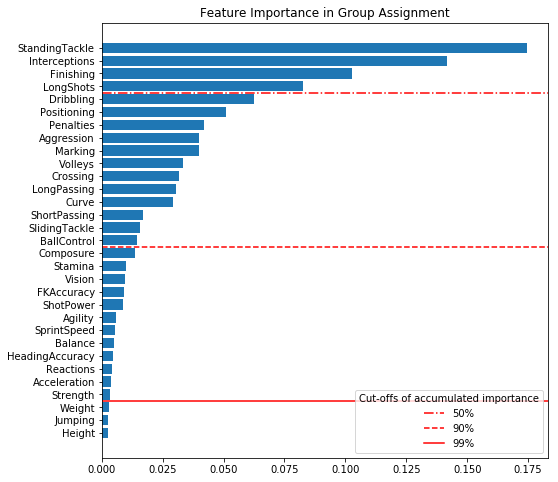

In [31]:
plt.figure(figsize = (8, 8))
plt.barh(df_imp['Features'], df_imp['Importance'], )
l1 = plt.axhline(len(df_imp) - (len(df_imp['Features'][df_imp['Sum Importance'] < 0.50]) + 1.5), linestyle = '-.', color = 'r')
l2 = plt.axhline(len(df_imp) - (len(df_imp['Features'][df_imp['Sum Importance'] < 0.90]) + 1.5), linestyle = '--', color = 'r')
l3 = plt.axhline(len(df_imp) - (len(df_imp['Features'][df_imp['Sum Importance'] < 0.99]) + 1.5), linestyle = '-', color = 'r')
plt.legend(title = 'Cut-offs of accumulated importance', handles = (l1, l2, l3), labels = ('50%', '90%', '99%'))
plt.title('Feature Importance in Group Assignment')

The 6 top features account for 50% of the accumulated importance; the next 10 add to 90% of importance, and we need extra 12 features to have 99% of importance. Curiously, the non-technical features, Weight and Height, are among the least important features.

## Conclusion

This exercise suggests that FIFA soccer players can be separated in 4 technical profiles, and also determines which are the most important technical features for assigning a player to its group. An analysis of this sort would be important, for example, to check if a player is assigned to its most efficient position in the field, and also to suggest which technical features should be improved (by physical training) to make sure a player is a good representative of desired technical profile.